## Clustering of field plots data RS observation
-----

In [2]:
# !pip3 -q install seaborn

In [1]:
import pandas as pd
import geopandas as gpd
import rasterio as rio 
from rasterio.mask import mask as crop_mask
import os 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt


import matplotlib.pyplot as plt
import numpy as np
from shapely import affinity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## 1. Read field-plots data 

In [100]:
fnames = {"invent_plots":"../shape_data/dataset_plots.geojson"}
gdf = gpd.read_file(fnames['invent_plots'])
gdf.loc[:, 'key'] = gdf.index

In [101]:
mask_non_forest = gdf['t_Class']>11
non_forest_gdf = gdf.loc[mask_non_forest]
# non_forest = dataset.prepare_forest_classes_dataset(gdf=non_forest_gdf)
non_forest_gdf.groupby('t_Class').count()

,Plot_ID,t_С,t_Л,t_Б,t_ОС,t_Е,t_П,t_К,t_Клас,geometry,key
t_Class,,,,,,,,,,,
12,0,0,0,0,0,0,0,0,1,11,11
13,1,0,0,0,0,0,0,0,0,12,12
14,0,0,0,0,0,0,0,0,1,12,12
15,1,0,0,0,0,0,0,0,1,12,12
16,0,0,0,0,0,0,0,0,1,10,10


In [4]:
def scale_geom(shape, scale:int):
    return affinity.scale(shape, xfact=scale, yfact=scale, origin='center')

def getRadius(x)->float:
    return np.sqrt(x.area/np.pi)

def get_datetime(fname:str):
    return dt.datetime.strptime(fname.split('.')[0], "%Y-%m-%d")

def plot_RGB_file(fname: str): 
    img = rio.open(fname)

    red = img.read(4)
    green = img.read(3)
    blue = img.read(2)

    red_b=brighten(red)
    blue_b=brighten(blue)
    green_b=brighten(green)

    red_bn = normalize(red_b)
    green_bn = normalize(green_b)
    blue_bn = normalize(blue_b)

    rgb_composite_bn= np.dstack((red_bn, green_bn, blue_bn))
    return rgb_composite_bn

def plot_RGB_matrix(img)->None: 
    red = img[4, ...]
    green = img[3, ...]
    blue = img[2, ...]
    red_b=brighten(red)
    blue_b=brighten(blue)
    green_b=brighten(green)

    red_bn = normalize(red_b)
    green_bn = normalize(green_b)
    blue_bn = normalize(blue_b)

    rgb_composite_bn= np.dstack((red_bn, green_bn, blue_bn))
    plt.imshow(rgb_composite_bn)

def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))


def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0,255)


def normalize_pixel(X):
    X = X/10000
    X = np.clip(X, 0, 0.3)
    return X

In [5]:

class Dataset:
    def __init__(self, tiff_fname=None):
        if tiff_fname:
            self.path_to_tiff_file = tiff_fname
        else:
            self.path_to_tiff_file = '/mnt/bulky2/mgasanov/CARBON/Sentinell2/ForestSentinell2/summer.tiff'
        self.dates_images = ['2019-07-01','2019-07-04', '2019-08-03', '2019-08-30',
                         '2020-07-03', '2020-07-05', '2020-07-13', '2020-08-04',
                         '2020-08-12', '2020-08-17', '2019-08-05', '2019-08-15',
                         '2020-08-09', '2019-08-08']
        self.path_to_terrain_file = '/mnt/bulky2/mgasanov/CARBON/Sentinell2/ForestSentinell2/terrain.tiff'
        
        self.terrain_cols = ["aspect", "slope", "wetnessindex","sink"]
        self.cols = self.get_all_cols()
    def get_all_cols(self):
        col_names = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12","CLM"]
        all_cols = []
        for date in sorted(self.dates_images):
            for col in col_names:
                all_cols.append(date+'_'+col)
        return all_cols
    
    def get_svi_cols(self):
        col_names = ["B01","B02","B03","B04","B05","B06","B07","B08",
                     "B8A","B09","B11","B12", "NDVI", "EVI", "MSAVI", "NDRE"] # CLM
        all_cols = []
        for date in sorted(self.dates_images):
            for col in col_names:
                all_cols.append(date+'_'+col)
        return all_cols

    
    def prepare_forest_classes_dataset(self, gdf: gpd.GeoDataFrame)->pd.DataFrame:

        df_indices_field = pd.DataFrame(columns = [*self.cols, "key",  'class'])
        print('Start bands', end=' ')
        for invent_plot_data in gdf.iterrows():

            inv_dict = invent_plot_data[1].to_dict()
            print(f"{inv_dict['key'] } ", end=' ')
            df = self.get_bands_by_shape(inv_dict, 1.0)
            df_indices_field = pd.concat([df_indices_field, df])
        
        df_indices_field = self.prepare_SVI(df_indices_field)
        
        print('Start terrain', end=' ')
        df_terrain = pd.DataFrame(columns = [*self.terrain_cols, "key",  'class'])
        for invent_plot_data in gdf.iterrows():

            inv_dict = invent_plot_data[1].to_dict()
            print(f"{inv_dict['key'] } ", end=' ')
            df = self.get_terrain_by_shape(inv_dict, 1.0)
            df_terrain = pd.concat([df_terrain, df])
        for col in self.terrain_cols:
            df_terrain.loc[:, col] = normalize(df_terrain[col])
        return df_indices_field, df_terrain
    
    def prepare_SVI(self, df:pd.DataFrame)->pd.DataFrame:
        for date in self.dates_images:
            df = self.get_ndvi(df, date)
            df = self.generate_NDRE(df, date)
            df = self.evi(df, date)
            df = self.generate_MSAVI(df, date)
        
        svi_cols = self.get_svi_cols()
        svi_cols.extend(['key', 'class'])
        return df[svi_cols]
        
    def get_bands_by_shape(self, invent_plot_data:dict, scale:float)->pd.DataFrame:
        """
        Get bands from geotiff by polygon mask

        Input: (Polygon) - shape

        Output: (pd.DataFrame) - df with bands, date, class 

        """

        shape = invent_plot_data['geometry']
        shape = scale_geom(shape=shape, scale=scale)
        with rio.open(self.path_to_tiff_file) as src:

            out_image, out_transform = crop_mask(src, 
                                                 [shape],
                                                 all_touched=True,
                                                 crop=True)

            out_meta = src.meta 
            x = out_image[:-4, ...].reshape(len(self.cols), out_image.shape[1]*out_image.shape[2])
        df = pd.DataFrame(x.T, columns=self.cols)
        mask = df.sum(axis=1)>0
        df = df.loc[mask]
        df.loc[:, 'key'] = invent_plot_data['key']
        df.loc[:, 'class'] = invent_plot_data['t_Class']
        df[self.cols] = normalize_pixel(df[self.cols].values)
        return df
    
    def get_terrain_by_shape(self, invent_plot_data:dict, scale:float)->pd.DataFrame:
        """
        Get terrain features from geotiff by polygon mask

        Input: (Polygon) - shape

        Output: (pd.DataFrame) - df with terrain, key, class 

        """

        shape = invent_plot_data['geometry']
        shape = scale_geom(shape=shape, scale=scale)
        with rio.open(self.path_to_tiff_file) as src:

            out_image, out_transform = crop_mask(src, 
                                                 [shape],
                                                 all_touched=True,
                                                 crop=True)

            out_meta = src.meta 
            s2 = out_image[2,...]
            sub_m = np.where(s2>0, out_image[-4:, ...], -1)
            x = sub_m[-4:, ...].reshape(len(self.terrain_cols), out_image.shape[1]*out_image.shape[2])

        df = pd.DataFrame(x.T, columns=self.terrain_cols)
        mask = df.max(axis=1)==-1
        df = df.loc[~mask]
        df.loc[:, 'key'] = invent_plot_data['key']
        df.loc[:, 'class'] = invent_plot_data['t_Class']        
    
        return df
    def get_ndvi(self, df: pd.DataFrame, date: str):
        red = df[f"{date}_B04"]
        nir = df[f"{date}_B08"]
        ndvi = (nir-red)/((nir+red).apply(lambda x: 0.000001 if x==0 else x))
        df.loc[:, f"{date}_NDVI"] = ndvi
        return df

    def evi(self, df: pd.DataFrame, date: str):
        red = df[f"{date}_B04"]
        nir = df[f"{date}_B08"]
        evi2 = 2.5*(nir - red)/((nir+ 2.4*red + 1).apply(lambda x: 0.000001 if x==0 else x))
        df.loc[:, f"{date}_EVI"] = evi2
        return df

    def generate_NDRE(self, df: pd.DataFrame, date: str):
        red_far = df[f"{date}_B05"]
        nir = df[f"{date}_B08"]
        ndre = (nir - red_far)/((nir + red_far).apply(lambda x: 0.000001 if x==0 else x))
        df.loc[:, f"{date}_NDRE"] = ndre
        return df

    def generate_MSAVI(self, df: pd.DataFrame, date: str):
        red = df[f"{date}_B04"]
        nir = df[f"{date}_B08"]
        msavi=(2*nir + 1 - ((2*nir+1)**2 - 8*(nir-red))**(1/2))/2
        df.loc[:, f"{date}_MSAVI"] = msavi
        return df

In [6]:
mask_forest = gdf['t_Class']<11
forest_gdf = gdf.loc[mask_forest]

In [7]:
dataset = Dataset(tiff_fname='../rasters/summer.tiff')
bands, terrain = dataset.prepare_forest_classes_dataset(gdf=gdf)

Start bands 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  200  201  202  203  204  205  206  207  208  209  210  211  212  213  214  215  216  217  218  219

/Users/mikhailgasanov/geo/lib/python3.8/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


Start terrain 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  200  201  202  203  204  205  206  207  208  209  210  211  212  213  214  215  216  217  218  2

In [127]:
bands

,2019-07-01_B01,2019-07-01_B02,2019-07-01_B03,2019-07-01_B04,2019-07-01_B05,2019-07-01_B06,2019-07-01_B07,2019-07-01_B08,2019-07-01_B8A,2019-07-01_B09,...,2020-08-17_B8A,2020-08-17_B09,2020-08-17_B11,2020-08-17_B12,2020-08-17_NDVI,2020-08-17_EVI,2020-08-17_MSAVI,2020-08-17_NDRE,key,class
0,0.0299,0.0250,0.0386,0.0248,0.0690,0.1873,0.2122,0.2031,0.2297,0.2290,...,0.2028,0.2074,0.0818,0.0354,0.808142,0.347513,0.325605,0.574572,0,7
1,0.0299,0.0264,0.0423,0.0267,0.0690,0.1873,0.2122,0.2128,0.2297,0.2290,...,0.2028,0.2074,0.0818,0.0354,0.826827,0.337413,0.314524,0.555177,0,7
2,0.0299,0.0255,0.0433,0.0245,0.0703,0.1919,0.2245,0.2281,0.2365,0.2290,...,0.2071,0.2074,0.0808,0.0359,0.832451,0.350835,0.328756,0.559197,0,7
3,0.0299,0.0274,0.0443,0.0272,0.0690,0.1873,0.2122,0.2174,0.2297,0.2290,...,0.2028,0.2074,0.0818,0.0354,0.809479,0.347356,0.325415,0.573878,0,7
4,0.0299,0.0272,0.0414,0.0275,0.0690,0.1873,0.2122,0.2288,0.2297,0.2290,...,0.2028,0.2074,0.0818,0.0354,0.826750,0.368453,0.347814,0.591709,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.0293,0.0291,0.0456,0.0342,0.0735,0.1699,0.1850,0.1829,0.1986,0.2181,...,0.1701,0.1767,0.1559,0.0965,0.694069,0.270400,0.247464,0.387894,287,15
5,0.0293,0.0326,0.0499,0.0364,0.0735,0.1699,0.1850,0.1935,0.1986,0.2181,...,0.1701,0.1767,0.1559,0.0965,0.689274,0.285886,0.263489,0.419563,287,15
6,0.0293,0.0288,0.0455,0.0312,0.0719,0.1829,0.2060,0.1912,0.2111,0.2181,...,0.1788,0.1767,0.1494,0.0933,0.696226,0.293537,0.271232,0.413522,287,15
7,0.0293,0.0314,0.0440,0.0325,0.0759,0.1772,0.1887,0.1687,0.2056,0.2181,...,0.1849,0.1767,0.1540,0.0932,0.715407,0.292912,0.270133,0.408541,287,15


## 2.  Remove correlated bands

In [8]:
print("All bands: ", len(bands.columns))


corr_matrix = bands.iloc[:, :-2].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]

# Drop features 
non_cor_bands = bands.drop(to_drop, axis=1)

print("Non correlated bands: ", len(non_cor_bands.columns))

All bands:  226
Non correlated bands:  50


<AxesSubplot:ylabel='Count'>

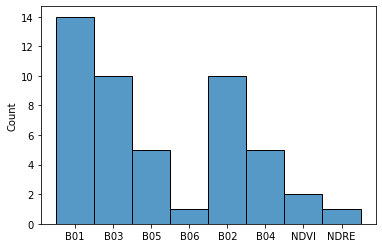

In [10]:
sns.histplot([x.split('_')[1] for x in cols_non_corrs[:-2]])

In [13]:
df = pd.concat([non_cor_bands.iloc[:,:-4], terrain], axis=1)

In [14]:
df

,2019-07-01_B01,2019-07-01_B03,2019-07-01_B05,2019-07-01_B06,2019-07-04_B01,2019-07-04_B02,2019-07-04_B03,2019-07-04_B04,2019-08-03_B01,2019-08-03_B02,...,2020-08-12_B02,2020-08-12_B03,2020-08-12_B04,2020-08-12_B05,aspect,slope,wetnessindex,sink,key,class
0,0.0299,0.0386,0.0690,0.1873,0.0234,0.0242,0.0394,0.0242,0.0254,0.0286,...,0.0339,0.0427,0.0252,0.0613,0.744318,0.036585,0.888889,0.811704,0,7
1,0.0299,0.0423,0.0690,0.1873,0.0234,0.0245,0.0366,0.0218,0.0254,0.0269,...,0.0339,0.0440,0.0235,0.0613,0.775568,0.04878,0.888889,0.811704,0,7
2,0.0299,0.0433,0.0703,0.1919,0.0234,0.0267,0.0358,0.0219,0.0254,0.0273,...,0.0334,0.0425,0.0256,0.0599,0.832386,0.04878,0.888889,0.831373,0,7
3,0.0299,0.0443,0.0690,0.1873,0.0234,0.0251,0.0383,0.0251,0.0254,0.0268,...,0.0327,0.0420,0.0258,0.0613,0.744318,0.036585,0.888889,0.811704,0,7
4,0.0299,0.0414,0.0690,0.1873,0.0234,0.0251,0.0401,0.0234,0.0254,0.0271,...,0.0331,0.0422,0.0249,0.0613,0.767045,0.060976,0.777778,0.811704,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.0293,0.0456,0.0735,0.1699,0.0245,0.0267,0.0436,0.0282,0.0261,0.0296,...,0.0351,0.0484,0.0361,0.0769,0.105114,0.02439,0.888889,0.85037,287,15
5,0.0293,0.0499,0.0735,0.1699,0.0245,0.0291,0.0484,0.0339,0.0261,0.0306,...,0.0389,0.0515,0.0394,0.0769,0.360795,0.02439,0.888889,0.800214,287,15
6,0.0293,0.0455,0.0719,0.1829,0.0245,0.0263,0.0442,0.0284,0.0261,0.0266,...,0.0338,0.0472,0.0347,0.0799,0.744318,0.0,0.0,0.85037,287,15
7,0.0293,0.0440,0.0759,0.1772,0.0245,0.0264,0.0432,0.0288,0.0261,0.0263,...,0.0336,0.0480,0.0361,0.0795,0.232955,0.036585,0.888889,0.85037,287,15


## 3. Random-undersampling of non-forest classes


In [78]:
# !pip -q install imbalanced-learn

In [46]:
bands.groupby('class').count()['key']

class
1       384
2       104
3        47
4       152
5       441
6       156
7       315
11    11996
12     2817
13     2274
14     1645
15      999
16      319
Name: key, dtype: int64

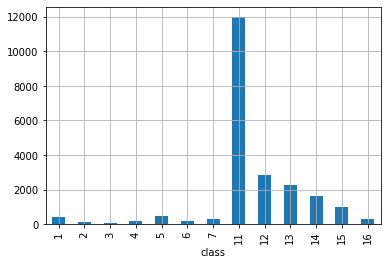

In [81]:
# how many pixels for each class
bands.groupby('class').count()['key'].plot(kind='bar')
plt.grid()

In [116]:
df[['aspect','slope','wetnessindex','sink']] = df[['aspect','slope','wetnessindex','sink']].astype(float)

mask = (df['class'] > 7) & (df['class']<16)
X_non_forest = df.loc[mask].drop(columns=['class']).values
y_non_forest = df.loc[mask, 'class'].astype(int).values

In [117]:
from collections import Counter

from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler 


# print('Original dataset shape %s' % Counter(y))

rus = RandomUnderSampler(random_state=42)

X_res, y_res = rus.fit_resample(X_non_forest, y_non_forest)

print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({11: 999, 12: 999, 13: 999, 14: 999, 15: 999})


In [118]:
sub_df_resampled= pd.DataFrame(X_res, columns=df.columns[:-1])
sub_df_resampled.loc[:, 'class'] = y_res

In [119]:
df.loc[mask_forest,'class'].unique()

array([5, 1, 6, 2, 3, 4, 16], dtype=object)

In [122]:
mask = (df['class'] > 7) & (df['class']<16)

df_resampled = pd.concat([df.loc[~mask], sub_df_resampled])

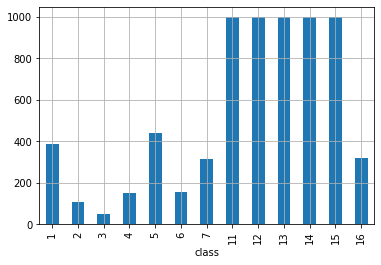

In [123]:
df_resampled.groupby('class').count()['key'].plot(kind='bar')
plt.grid()

## 4. Select models

In [97]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error


from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from scipy.stats import loguniform

In [94]:
X = df_resampled.drop(columns='class').astype('float')
Y = df_resampled['class'].astype(int)

SVC: 0.026878 (0.029535)
RandomForest: 0.215706 (0.184424)
GB: 0.209107 (0.179765)
RidgeClassifier: 0.076981 (0.101963)


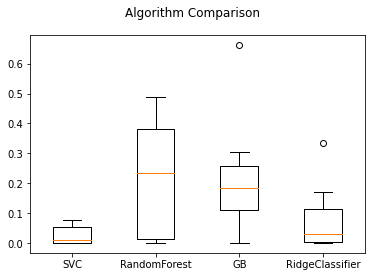

In [98]:
seed = 7
models = []
models.append(('SVC', SVC()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('RidgeClassifier', RidgeClassifier()))

results = []
names = []
# scoring = {"OA":"balanced_accuracy", "f1_macro":'f1_macro'}
scoring= 'f1_macro'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
# plt.savefig('../plots/models_comparison.png', dpi=150)
plt.show()


In [89]:
import sklearn

In [126]:
## two-metrics scoring
scoring = {"OA":"balanced_accuracy", "f1_macro":'f1_macro'}

param_grid = {
    "n_estimators": range(5, 100, 10),
    "max_leaf_nodes": range(2, 100, 10),
    "min_samples_split": range(2, 50, 5),
    "learning_rate": loguniform.rvs(0.01, 1, size=10),
}

gs = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    n_iter=100,
    param_distributions=param_grid,
    scoring=scoring,
    cv=5,
    refit="f1_macro",
    n_jobs=-1,
    return_train_score=True,
    verbose=3
)
gs.fit(X, Y)
results = gs.cv_results_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [ ]:


mape = results['mean_test_OA']
r2 = results['mean_test_f1_macro']

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), tight_layout=True)
ax1.scatter(mape*100, r2, edgecolors=sns.color_palette()[0], facecolors='none')
ax1.grid()
# ax1.set_ylim(0,1)
# ax1.set_xlim(0,10)
ax1.set_ylabel("$R^2$")
ax1.set_xlabel("$MAPE$")
# ax2.scatter(mape_normalized, r2_normalize)
sns.kdeplot(r2, fill=True, label="$R^2$", ax=ax2)
ax2.grid()
ax2.legend()
sns.kdeplot(mape, fill=True, label="$MAPE$, %", ax=ax3)
ax3.grid()
ax3.legend()
# ax2.set_ylabel("$R^2$")
# ax2.set_xlabel("$MAPE$")
plt.savefig('../plots/two_metrics_plots.png', dpi=300)

## 2. EDA

In [3]:
# # Fill diagonal and upper half with NaNs
# corr = non_forest.corr()
# mask = np.zeros_like(corr, dtype=bool)
# mask[np.triu_indices_from(mask)] = True
# corr[mask] = np.nan
# (corr.iloc[::3, ::2]
#  .style
#  .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
#  .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
#  .set_precision(2))

In [353]:
corr_matrix = non_forest.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features 
non_forest.drop(to_drop, axis=1, inplace=True)

In [1]:
# # Fill diagonal and upper half with NaNs
# corr = non_forest.corr()
# mask = np.zeros_like(corr, dtype=bool)
# mask[np.triu_indices_from(mask)] = True
# corr[mask] = np.nan
# (corr.iloc[:, :]
#  .style
#  .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
#  .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
#  .set_precision(2))

## 3. Plotting


In [ ]:
path='/mnt/bulky2/mgasanov/CARBON/Sentinell2/ForestSentinell2/'
list_of_geotiff = [tiff for tiff in os.listdir(path) if 'tiff' in tiff]
mask = (df_indices_field['date'].dt.month>6) & (df_indices_field['date'].dt.month<9)
dates_images = df_indices_field.loc[mask, 'date'].unique()
dates_images = [str(image)[:10] for image in dates_images]

In [148]:
src = rio.open(path_to_tiff_file)

In [100]:
dataset = Dataset()
src = rio.open(dataset.path_to_tiff_file)

In [101]:
X = src.read()

In [102]:
X.shape 

(186, 3462, 3159)

In [24]:
dataset.path_to_tiff_file

'/mnt/bulky2/mgasanov/CARBON/Sentinell2/ForestSentinell2/summer.tiff'

In [20]:
s2 = rio.open("/mnt/bulky2/mgasanov/CARBON/Sentinell2/ForestSentinell2/2019-06-19.tiff")
s2.read().shape

(13, 3300, 2966)

In [153]:
def normalize(X):
    X = X/10000
    X = np.clip(X, 0, 0.3)
    return X

In [162]:
X = normalize(124)

In [220]:
for x in sorted(dates_images):
    print(x+'.tiff ', end='')

2019-07-01.tiff 2019-07-04.tiff 2019-08-03.tiff 2019-08-05.tiff 2019-08-08.tiff 2019-08-15.tiff 2019-08-30.tiff 2020-07-03.tiff 2020-07-05.tiff 2020-07-13.tiff 2020-08-04.tiff 2020-08-09.tiff 2020-08-12.tiff 2020-08-17.tiff 

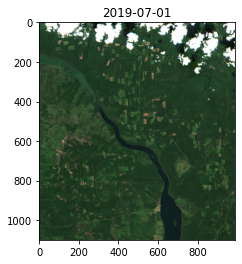

In [147]:
for tiff_file in sorted(dates_images):
    path_to_tiff_file = os.path.join(path, tiff_file+'.tiff')
    print()
    rgb_composite_bn = plot_RGB_file(path_to_tiff_file)
    plt.imshow(rgb_composite_bn[::3, ::3, :])
    plt.title(tiff_file.split('.')[0])
    plt.show()
    break

In [114]:
shape = gdf.iloc[0,-2]

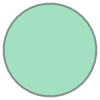

In [115]:
shape

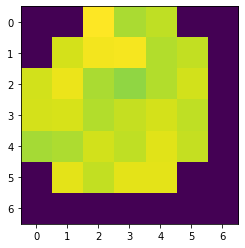

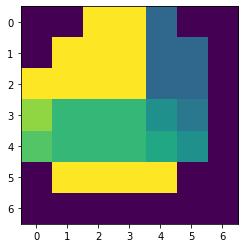

In [136]:


shape = gdf.iloc[-2,-2]


with rio.open(dataset.path_to_tiff_file) as src:
    out_image, out_transform = crop_mask(src, [shape], crop=True, nodata=0) # SUPER KEK - [shape] works, shape - doesn't 
    out_meta = src.meta 
#     x = out_image[:12, ...].reshape(12, out_image.shape[1]*out_image.shape[2])
# _df = pd.DataFrame(x.T, columns=col_names[:-1])
#     df
# plt.imshow(out_image[3,...])

plt.imshow(out_image[1,...])
plt.show()

plt.imshow(out_image[-4,...])
plt.show()

In [137]:
s2 = out_image[2,...]

t1 = out_image[-2,...]

sub_m = np.where(s2>0, t1, -1)

In [138]:
s2.shape

(7, 7)

In [145]:
sub_m = np.where(s2>0, t1, -1)

array([[-1, -1,  0,  0,  8, -1, -1],
       [-1,  0,  0,  0,  8,  8, -1],
       [ 8,  0,  0,  0,  8,  8, -1],
       [ 8,  8,  8,  8,  8,  8, -1],
       [ 8,  8,  8,  8,  8,  9, -1],
       [-1,  0,  0,  0,  0, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1]], dtype=int32)

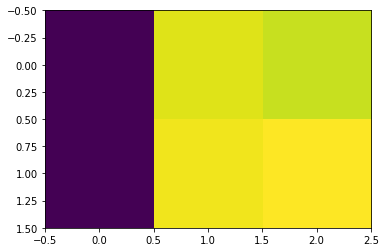

In [119]:
plt.imshow(out_image[1,...])

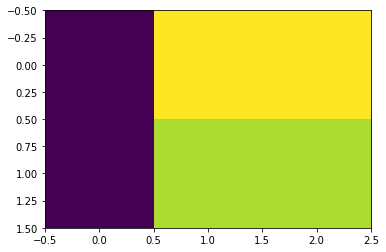

In [123]:
plt.imshow(out_image[-2,...])

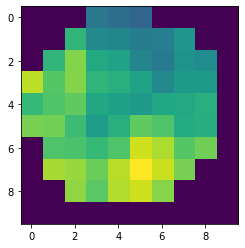

In [73]:
col_names = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12","CLM"]
path='/Users/mikhailgasanov/Yandex.Disk.localized/STRIP/Bratsk/Sentinel2_2019_10_meters/'
year = 2019
list_of_geotiff = [tiff for tiff in os.listdir(path) if (str('-') in tiff) and ('tiff' in tiff)]

df_indices_field = pd.DataFrame(columns = ['date',  *col_names, "NDVI"])

dates_of_images = []



for tiff_file in sorted(list_of_geotiff):
    path_to_tiff_file = os.path.join(path, tiff_file)
    with rio.open(path_to_tiff_file) as src:
        out_image, out_transform = crop_mask(src, [shape], crop=True) # SUPER KEK - [shape] works, shape - doesn't
        out_meta = src.meta 
        x = out_image[:12, ...].reshape(12, out_image.shape[1]*out_image.shape[2])
    _df = pd.DataFrame(x.T, columns=col_names[:-1])
#     df
plt.imshow(out_image[3,...])

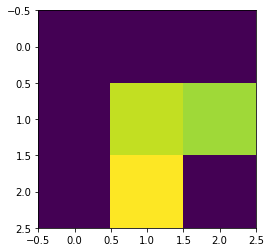

In [75]:
shape = gdf_8m.iloc[0,-1]
col_names = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12","CLM"]
path='/Users/mikhailgasanov/Yandex.Disk.localized/STRIP/Bratsk/Sentinel2_2019_10_meters/'
year = 2019
list_of_geotiff = [tiff for tiff in os.listdir(path) if (str('-') in tiff) and ('tiff' in tiff)]

df_indices_field = pd.DataFrame(columns = ['date',  *col_names, "NDVI"])

dates_of_images = []



for tiff_file in sorted(list_of_geotiff):
    path_to_tiff_file = os.path.join(path, tiff_file)
    with rio.open(path_to_tiff_file) as src:
        out_image, out_transform = crop_mask(src, [shape], crop=True) # SUPER KEK - [shape] works, shape - doesn't
        out_meta = src.meta 
        x = out_image[:12, ...].reshape(12, out_image.shape[1]*out_image.shape[2])
    _df = pd.DataFrame(x.T, columns=col_names[:-1])
#     df

plt.imshow(out_image[3,...])

In [16]:
gdf_8m.crs

<Derived Projected CRS: EPSG:32647>
Name: WGS 84 / UTM zone 47N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 96°E and 102°E, northern hemisphere between equator and 84°N, onshore and offshore. China. Indonesia. Laos. Malaysia - West Malaysia. Mongolia. Myanmar (Burma). Russian Federation. Thailand.
- bounds: (96.0, 0.0, 102.0, 84.0)
Coordinate Operation:
- name: UTM zone 47N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich